# Amplitude Estimation Refactor

Note on this design doc: First motivate new features and changes of current implementations. Then discuss a possible implementation for each feature. If multiple designs are feasible, discuss these and present a final suggestion.

# Motivation

What features are we currently missing? What's too complicated to use? Is anything implemented in an inefficient manner?

### Generalization of the input operators 

The goal of AE is to approximate the amplitude $a$ of the so-called 'good' states, encoded in an operator A:

$$
A|0> = \sqrt{1 - a} |\psi_0> |0> + \sqrt{a} |\psi_1> |1>
$$

For this, we set up a secondary operator $Q = A S_0 A^{-1} S_{\psi_0}$, where $S_0$ flips about the $|0\rangle$ state and $S_{\psi_0}$ about the 'bad' state. In principle, providing the $A$ operator suffices to run AE, since we can build $Q$ ourselves by implicitely assuming that the 'good' state is marked by the state $|1\rangle$ in the last qubit.
However, that is a restrictive design and the 'good' state can be far more general. Also, depending on the hardware, we might know a more efficient implementation of S_0 than the default one. That argument also holds for the $Q$ operator, which can in some cases be massively simplified. (ref. Bernoulli A Operator).


Therefore, we should be able to set the operators $S_0$, $S_{\psi_0}$ and $Q$ manually. For the $Q$ operator that's currently possible, but we should also allow this for the $S$ operators.

In [ ]:
ae = AmplitudeEstimation(..., i_objective=1)
ae = AmplitudeEstimation(..., i_objective=[1,2,5])
ae = AmplitudeEstimation(..., S_psi=objective_oracle)

QPE-free variants may require a filter function, specifying what measurement outcomes are 'good'.

In [ ]:
ae = MaximumLikelihoodAmplitudeEstimation(..., measurement_qubits=[1, 2, 5], objective_filter=good_state_requirement)

In this scenario, `good_state_requirement` takes (a list of) 3 bits, since we measure 3 qubits, and returns a boolean/binary output.

### Progressive execution 

To run algorithms on real hardware it may be necessary to (manually) optimize the circuits or re-run them several times to find the best settings. Therefore, algorithms should be able to yield the circuits they execute, let us optimize & execute them to then plug the execution result back into the algorithm. For iterative algorithms this should be possible for every single iteration. This is optional and we may want to choose which iterations are done automatically and which we want to analyze in detail or run manually. Thus, an algorithm should have a state that can be read and set as appropriate combined with a method to run a single iteration given the state.

### Type of the input operators 

In the circuit for AE, we require controlled versions of the $A$ operator (and $S$, $Q$), powers of it and controlled powers. 
Since in the earlier Qiskit, we had no object to handily provide these versions, the `CircuitFactory` type has been introduced. 
Given an implementation of the abstract `build` function, that constructs a quantum circuit, the `CircuitFactory` provides powers, controlled powers, inverses, etc. of that circuit. 
As these features are now provided with Terra's `Gate` class, the `CircuitFactory` is obsolete and should be deprecated. 
Instead, we can use the `Gate`.
This avoids the duplicate implementation of the same functionality and gives the user one less type to learn about. 

Note, that the `CircuitFactory` is only used in AE and for `UncertaintyModels/Problems` -- which in turns have been created (mostly? only?) for AE.

### Result object

This is coming anyways, just as a note: All AE-type algorithms should return a `AmplitudeEstimationResult` instead of a dict.  

### Parallel execution 

Algorithms that can execute multiple circuits in parallel should do this to speedup the computation. Currently, this affects only MLAE.

### Summary

* allow the manual execution of circuits in each iteration
* accept a general $S_{\psi_0}$ operator to detect good/bad states
* use a results object
* run circuits in parallel, where possible

# Possible implementations

This section discusses possible implementations of the requirements motivated in the previous section. If multiple implementations seem feasible, they should be mentioned and discussed. More possible versions can be added.

### Generalized input 

The current inheritance structure can be kept. The `AmplitudeEstimationAlgorithm` base class should manage all possible inputs for the different $A$, $Q$ and $S$ operators. If an algorithm has restrictions on these operators, this can be handled in the individual initializers.
With this design, we spare a lot of copy+paste and as compared to implementing all inputs for all types of AE algorithms. 

### Progressive execution:

To allow the progressive executions, the current implementations of `_run` are not suitable.

#### Design 1 

Since in every iteration, the circuits are created via `construct_circuit` and then the information processed, divide the running of an algorithm explicitely in the three steps: 
construct the circuit, process the outcome, check the termination. 
Every iteration calls these three functions. 
The user can intervene at any point by requesting the circuit and feeding the outcome into the process function. 

While the default way should still be supported:

In [ ]:
ae = AE(...)
result = ae.run()

The progressive execution could look something like this:

In [ ]:
ae = AE(...)
ae.initialize()  # initializes / clears the algorithm's state

# example iteration loop, can be changed as appropriate
for _ in range(num_iterations):  
    # get the current state of the algorithm and the circuits to be executed
    state = ae.get_state()  # returns a dictionary with relevant properties
    circuits = ae.get_circuits(state['x'], state['y'], ...)  # may be a single circuit or a set of circuits
    
    # run the job manually -- hardware specific changes or other tuning possible
    job = execute(circuits, ...)
    results = job.results()
    
    # update state based on results and previous state
    # possibly, this could return True/False based on the termination criterion of the iterative algorithm
    ae.process_results(results, state['x', prop['y'], ...]) 

result = ae.finalize()  # perform whatever post-processing may be necessary

Note, that for non-iterative algorithms, i.e. all circuits to be executed are known, the manual execution would look the same way, except leaving out the for-loop.

To be able to yield the next circuit of the iteration, the algorithm must know the current iteration state. This could be handled by a `iteration_state` dict/object. Other possibilities would a set of private members (code explosion, no differentiation between state variables and others) or a new class (overkill, confusing, does the same job as a dict).

##### Advantages

* modular execution of each step


##### Issues 

* need to introduce new methods, we need to ensure these are not confusing to the user
iterative and non-iterative algorithms have slightly different interfaces (bc of `run_iteration`)

#### Conclusion

For the iterative algorithms, implement a `run_iteration` function, that either runs an iteration with the quantum instance provided to `run` or accepts a simulation result from the current circuit. This circuit can be obtained via `construct_next_circuit`. 
For non-iterative algorithms, let `run` accept a circuit result. This circuit can obtained from `construct_circuit`.

### Type of input operators

Problems arising from removing the `CircuitFactory`:
How to do the c-scaling, which currently was done via the `value_to_estimation` method of the A `CircuitFactory`?
the `CircuitFactory` knew the number of required ancillas. 
How do we handle this with a `Gate`? What order of qubits of state and ancilla and objective qubits do we impose? (currently `i_objective`, `i_state`, `i_ancillas`)

#### Design 1: Operators are Gates

Provide the $A$/$Q$/$S$ operators as `Gate` and separately a function `value_to_estimation`. Impose a fixed ordering of the qubit indices for state qubits, ancillas and objective qubit. In this design, generating the $Q$ operator from the $A$ operator would be done in a utility function.

#### Design 2: Operators derived from Gates

Use a new class `AOperator` (or similar), holding a `Gate` and providing the required extra functionality. In this design, the $Q$ operator could be another class, accepting an `AOperator` in the initializer (as it is now)

#### Discussion & Conclusion

| Design 1 | Design 2 |
| -----------| ------------|
| + No new classes | - New intermediate classes required | 
| + More flexibility in the inputs for AE | + All required information sits in one place |
| - Implicit qubit ordering needed | + Lots of flexibility in the implementation |
| - New utility functions required | + Similar to current structure | 

Both versions are possible, though new `A/QOperator` classes might be more elegant and easier to maintain. It would be possible to allow also a `Gate` as $A$ operator instead of an `AOperator` instance to allow more general input and make the use of AE simpler.

### Result object

All AE algorithms must set certain fixed members of the results object, these include
* `estimate` / `estimation`
* `a_estimate` / `a_value` / `value`


Optionally, if possible, extend by these keywords
* `num_oracle_calls`
* `confidence_interval` (of some confidence level)


Plus some algorithm specific attributes. Theses can for instance be histories of certain internal variables. Maybe use a separate history dictionary to encapsulate the information. 
The history could then be enable using a particular flag, and optionally be dumped to a file, which can be very convenient for testing and debugging. If algorithm states would be used, the whole state could be saved.

### Parallel execution

Construct all circuits at once and execute them jointly. 

In [35]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Instruction, Gate

In [14]:
class AOperator(Gate):
    def __init__(self):
        pass
    
    def define(self, qc):
        gate = qc.to_gate()
        super().__init__(gate.name, gate.num_qubits, gate.params, gate.label)
        self.definition = gate.definition

In [15]:
qc = QuantumCircuit(1)
qc.x(0)

In [21]:
# A operator
A = AOperator()
qc = QuantumCircuit(1)
qc.x(0)
A.define(qc)


# Q operator (for testing purpose also of type AOperator)
Q = AOperator()
qc = QuantumCircuit(1)
qc.x(0)
qc.z(0)
Q.define(qc)

In [31]:
m = 3
i_objective = m
ae = QuantumCircuit(m + 1)

ae.append(A, qargs=[i_objective])  # A operator

# Q operators
for mi in range(m):
    ae.barrier()
    if mi == 0:
        ae.append(Q.control(), qargs=[mi, i_objective])
    else:
        ae.append(Q.repeat(mi).control(), qargs=[mi, i_objective])

# iqft = IQFT(m)
# ae.append(iqft, qargs=list(range(m)))

In [32]:
print(ae.draw())

                      ░               ░                 ░                
q_0: |0>──────────────░───────■───────░─────────────────░────────────────
                      ░       │       ░                 ░                
q_1: |0>──────────────░───────┼───────░────────■────────░────────────────
                      ░       │       ░        │        ░                
q_2: |0>──────────────░───────┼───────░────────┼────────░────────■───────
        ┌───────────┐ ░ ┌─────┴─────┐ ░ ┌──────┴──────┐ ░ ┌──────┴──────┐
q_3: |0>┤ Circuit18 ├─░─┤ Circuit19 ├─░─┤ Circuit19*1 ├─░─┤ Circuit19*2 ├
        └───────────┘ ░ └───────────┘ ░ └─────────────┘ ░ └─────────────┘


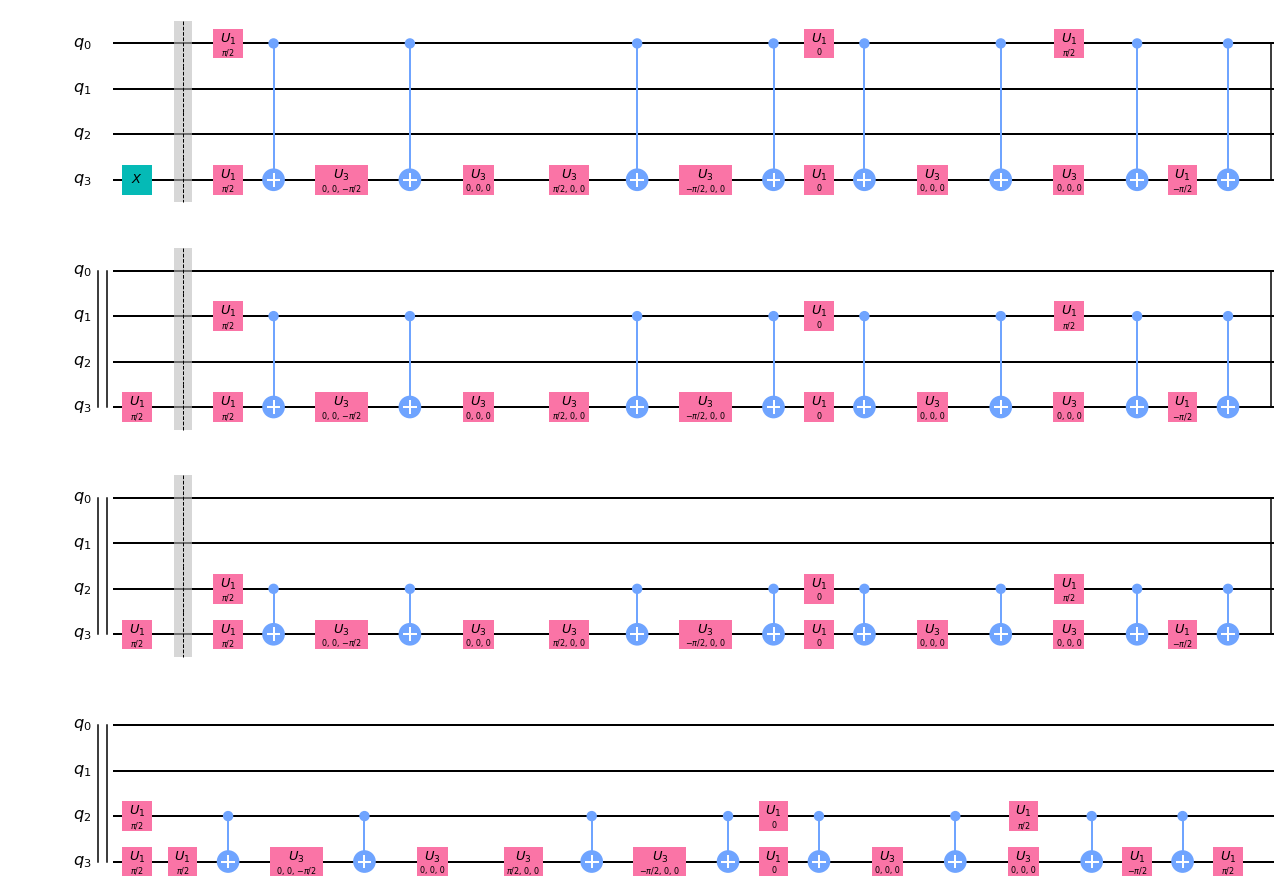

In [42]:
ae.decompose().draw(output='mpl')